In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
from numpy.linalg import LinAlgError

# Load dataset
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 44.xlsx"
df = pd.read_excel(file_path)

# ✅ Drop rows where Y variable is missing
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)

# ✅ Ensure Timestamp is integer
df["Timestamp"] = df["Timestamp"].astype(int)

# ✅ Define Moving Window Parameters
rolling_window = 36  # 36-month rolling window

# ✅ Define Y (Target Variable) and X (Features)
y_var = "Return_Next 3M"
x_vars = df.columns[3:]  # Excluding "PERMNO" and "Timestamp"

# ✅ Prepare Storage for Rolling Predictions
rolling_predictions = []

# ✅ Get Unique Timestamps
timestamps = sorted(df["Timestamp"].unique())

# ✅ Fix: Adjust Loop Range to Prevent Index Errors
for i in range(len(timestamps) - rolling_window - 5):
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]  # 36 months window

    if (i + rolling_window + 5) >= len(timestamps):
        break  # Stop if the test period goes beyond dataset

    test_start = timestamps[i + rolling_window + 3]
    test_end = timestamps[i + rolling_window + 5]

    validation_start = timestamps[i + rolling_window]
    validation_end = timestamps[i + rolling_window + 2]

    # ✅ Select Data for Each Period
    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    test_data = df[(df["Timestamp"] >= test_start) & (df["Timestamp"] <= test_end)]
    validation_data = df[(df["Timestamp"] >= validation_start) & (df["Timestamp"] <= validation_end)]

    # ✅ Debug: Check Data Sizes
    print(f"🟢 Processing Timestamp {train_end} | Train: {len(train_data)}, Test: {len(test_data)}, Validation: {len(validation_data)}")

    # ✅ Ensure there is enough data
    if len(train_data) < rolling_window or len(test_data) == 0 or len(validation_data) == 0:
        print(f"⚠️ Skipping Timestamp {train_end} due to insufficient data")
        continue

    # ✅ Prepare X and Y Matrices with Constant Column
    X_train = sm.add_constant(train_data[x_vars], has_constant="add")
    y_train = train_data[y_var]

    X_validation = sm.add_constant(validation_data[x_vars], has_constant="add")
    X_test = sm.add_constant(test_data[x_vars], has_constant="add")

    # ✅ Check for Missing or Constant Columns
    if X_train.isnull().values.any() or y_train.isnull().values.any():
        print(f"⚠️ Skipping Timestamp {train_end} due to NaN values in dataset")
        continue

    if y_train.nunique() == 1:
        print(f"⚠️ Skipping Timestamp {train_end} due to constant target variable")
        continue

    # ✅ Check Condition Number (Detect Multicollinearity)
    condition_number = np.linalg.cond(X_train)
    print(f"📊 Condition Number: {condition_number:.2f}")

    if condition_number > 1000:
        print(f"⚠️ High multicollinearity detected at {train_end}, switching to Ridge Regression")

        # 🔹 **Use Ridge Regression**
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)

        # ✅ Store coefficients separately
        intercept = ridge_model.intercept_
        latest_coefficients = ridge_model.coef_

    else:
        try:
            rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()
            latest_coefficients = rolling_model.params.iloc[-1].values
        except LinAlgError:
            print(f"⚠️ Singular matrix error at {train_end}, switching to Ridge Regression")

            # 🔹 **Use Ridge Regression as fallback**
            ridge_model = Ridge(alpha=1.0)
            ridge_model.fit(X_train, y_train)

            # ✅ Store coefficients separately
            intercept = ridge_model.intercept_
            latest_coefficients = ridge_model.coef_

    # ✅ Compute Predictions
    validation_predictions = np.dot(X_validation, latest_coefficients)  # Fixed shape issue
    test_predictions = np.dot(X_test, latest_coefficients)  # Fixed shape issue

    # ✅ Store Predictions
    validation_data = validation_data.copy()
    test_data = test_data.copy()

    validation_data["Predicted_Return_Next_3M"] = validation_predictions
    test_data["Predicted_Return_Next_3M"] = test_predictions

    rolling_predictions.append(validation_data)
    rolling_predictions.append(test_data)

    # ✅ Debugging: Print Sample Predictions
    print(validation_data[["Timestamp", "Predicted_Return_Next_3M"]].head())

# ✅ Check if rolling_predictions is empty
if len(rolling_predictions) == 0:
    raise ValueError("🚨 No valid predictions were generated. Check the loop conditions!")

# ✅ Combine All Rolling Predictions
final_predictions = pd.concat(rolling_predictions, ignore_index=True)

# ✅ Compare Predictions vs Actual Top 1 Stock
top_1_actual = final_predictions.nlargest(1, y_var)
top_1_predicted = final_predictions.nlargest(1, "Predicted_Return_Next_3M")

# ✅ Display Top 1 Stocks (Actual vs Predicted)
print("📊 **Actual Top 1 Stock (Based on Real Returns)**")
print(top_1_actual[["Timestamp", "PERMNO", y_var]])

print("\n📈 **Predicted Top 1 Stock (Based on Model Forecast)**")
print(top_1_predicted[["Timestamp", "PERMNO", "Predicted_Return_Next_3M"]])

# ✅ Save Results
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 46.xlsx"
final_predictions.to_excel(output_file, index=False)
print(f"✅ Moving Window Regression Completed! Results saved as: {output_file}")


Mounted at /content/drive
🟢 Processing Timestamp 200512 | Train: 14891, Test: 1293, Validation: 1272
📊 Condition Number: 25.13
       Timestamp  Predicted_Return_Next_3M
14891     200601                 -0.424572
14892     200601                  0.514609
14893     200601                  0.590112
14894     200601                 -0.332181
14895     200601                  2.050420
🟢 Processing Timestamp 200601 | Train: 14996, Test: 1294, Validation: 1282
📊 Condition Number: 25.56
       Timestamp  Predicted_Return_Next_3M
15312     200602                  0.270008
15313     200602                  1.545143
15314     200602                 -0.222970
15315     200602                 -0.133761
15316     200602                  1.900790
🟢 Processing Timestamp 200602 | Train: 15006, Test: 1296, Validation: 1289
📊 Condition Number: 25.99
       Timestamp  Predicted_Return_Next_3M
15736     200603                 -0.108145
15737     200603                 -0.437681
15738     200603          

🟢 Processed Timestamp 200512 | R-Squared: 0.6592
🟢 Processed Timestamp 200601 | R-Squared: 0.6613
🟢 Processed Timestamp 200602 | R-Squared: 0.6619
🟢 Processed Timestamp 200603 | R-Squared: 0.6626
🟢 Processed Timestamp 200604 | R-Squared: 0.6651
🟢 Processed Timestamp 200605 | R-Squared: 0.6664
🟢 Processed Timestamp 200606 | R-Squared: 0.6702
🟢 Processed Timestamp 200607 | R-Squared: 0.6726
🟢 Processed Timestamp 200608 | R-Squared: 0.6744
🟢 Processed Timestamp 200609 | R-Squared: 0.6699
🟢 Processed Timestamp 200610 | R-Squared: 0.6763
🟢 Processed Timestamp 200611 | R-Squared: 0.6740
🟢 Processed Timestamp 200612 | R-Squared: 0.6748
🟢 Processed Timestamp 200701 | R-Squared: 0.6749
🟢 Processed Timestamp 200702 | R-Squared: 0.6739
🟢 Processed Timestamp 200703 | R-Squared: 0.6733
🟢 Processed Timestamp 200704 | R-Squared: 0.6757
🟢 Processed Timestamp 200705 | R-Squared: 0.6724
🟢 Processed Timestamp 200706 | R-Squared: 0.6721
🟢 Processed Timestamp 200707 | R-Squared: 0.6763
🟢 Processed Timestam

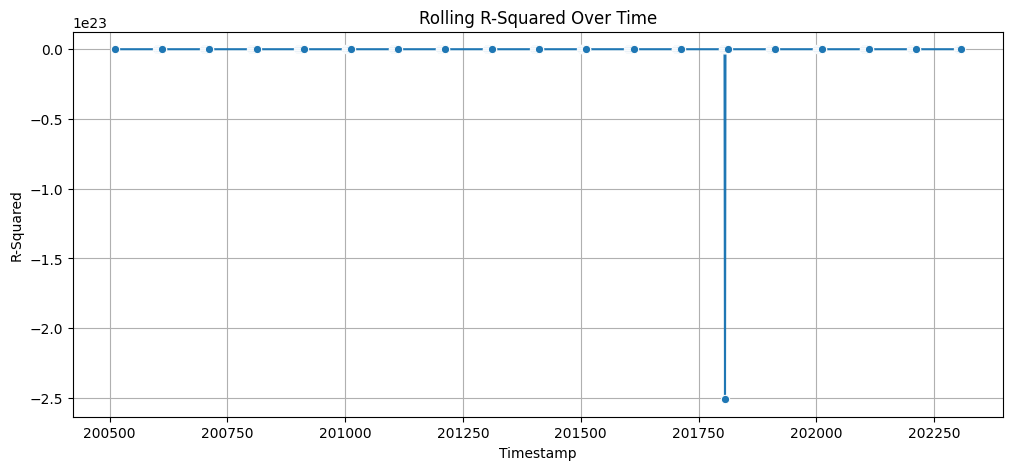

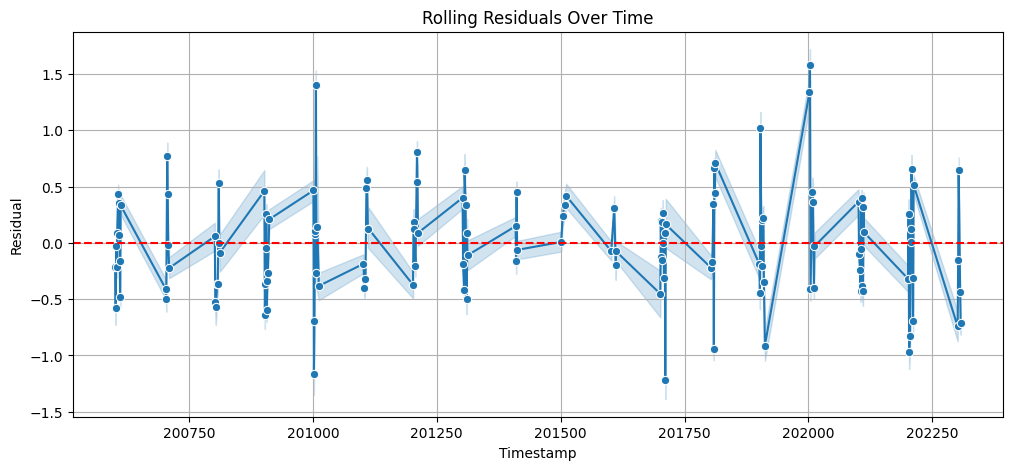

✅ RollingOLS Diagnostics Saved Successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# ✅ Initialize Storage for Diagnostics
rolling_coefficients = []
r_squared_values = []
timestamps_recorded = []

# Instead of one residuals_storage list, use separate lists
residuals_values = []     # To store each residual value
residuals_timestamps = [] # To store the corresponding timestamp for each residual

# ✅ Run RollingOLS and Collect Diagnostics
for i in range(len(timestamps) - rolling_window - 5):
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]

    if (i + rolling_window + 5) >= len(timestamps):
        break

    train_data = df[(df["Timestamp"] >= train_start) & (df["Timestamp"] <= train_end)]
    validation_data = df[df["Timestamp"] == timestamps[i + rolling_window]]  # Next timestamp validation

    # ✅ Ensure Data Availability
    if len(train_data) < rolling_window or validation_data.empty:
        continue

    # ✅ Prepare X and Y
    X_train = sm.add_constant(train_data[x_vars], has_constant="add")
    y_train = train_data[y_var]

    X_validation = sm.add_constant(validation_data[x_vars], has_constant="add")

    # ✅ Run RollingOLS
    rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()

    # ✅ Store Coefficients at Last Rolling Step
    latest_coefficients = rolling_model.params.iloc[-1].values
    rolling_coefficients.append(latest_coefficients)

    # ✅ Store R-Squared
    avg_r_squared = rolling_model.rsquared.mean()
    r_squared_values.append(avg_r_squared)
    timestamps_recorded.append(train_end)

    # ✅ Compute Fitted Values & Residuals Manually on Validation Data
    fitted_values = np.dot(X_validation, latest_coefficients)
    actual_values = validation_data[y_var].values

    # ✅ For each residual, record the corresponding validation timestamp
    if len(actual_values) == len(fitted_values):
        residuals = actual_values - fitted_values
        for r in residuals:
            residuals_values.append(r)
            # Using the validation timestamp here (timestamps[i + rolling_window])
            residuals_timestamps.append(timestamps[i + rolling_window])
    else:
        # In case of mismatch, store NaN for each expected residual
        for _ in range(len(actual_values)):
            residuals_values.append(np.nan)
            residuals_timestamps.append(timestamps[i + rolling_window])

    print(f"🟢 Processed Timestamp {train_end} | R-Squared: {avg_r_squared:.4f}")

# ✅ Convert Data to DataFrame
coefficients_df = pd.DataFrame(rolling_coefficients, columns=["Intercept"] + list(x_vars), index=timestamps_recorded)
r_squared_df = pd.DataFrame({"Timestamp": timestamps_recorded, "R-Squared": r_squared_values})
residuals_df = pd.DataFrame({"Timestamp": residuals_timestamps, "Residual": residuals_values})

# ✅ Plot R-Squared Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="R-Squared", data=r_squared_df, marker="o")
plt.title("Rolling R-Squared Over Time")
plt.xlabel("Timestamp")
plt.ylabel("R-Squared")
plt.grid(True)
plt.show()

# ✅ Plot Residuals Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="Residual", data=residuals_df, marker="o")
plt.title("Rolling Residuals Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Residual")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# ✅ Save Rolling Diagnostics (ensure your drive is mounted if running in Colab)
coefficients_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Coefficients.csv")
r_squared_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_RSquared.csv")
residuals_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Residuals.csv")

print("✅ RollingOLS Diagnostics Saved Successfully!")


In [ ]:
# Assume df, x_vars, y_var, and rolling_window (e.g. 36) are already defined

# 1. Define the training window: use the last 36 unique timestamps prior to 202312
available_timestamps = sorted(df["Timestamp"].unique())
train_candidates = [t for t in available_timestamps if t < 202312]

if len(train_candidates) < rolling_window:
    raise ValueError("Not enough training data available prior to 202312.")

# Select the last 36 timestamps as the training window
train_window = train_candidates[-rolling_window:]
print("Training window:", train_window)

# Filter training data based on the training window
train_data = df[df["Timestamp"].isin(train_window)]

# 2. Prepare design matrix for training
X_train = sm.add_constant(train_data[x_vars], has_constant="add")
y_train = train_data[y_var]

# 3. Fit the RollingOLS model on the training data and extract the last coefficients
rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()
last_coefficients = rolling_model.params.iloc[-1].values
print("Last model coefficients extracted.")

# 4. Filter data for timestamp 202312 (the prediction period)
pred_data = df[df["Timestamp"] == 202312].copy()

# Check that prediction data exists
if pred_data.empty:
    raise ValueError("No data found for timestamp 202312. Please verify your dataset.")

# Prepare design matrix for prediction
X_pred = sm.add_constant(pred_data[x_vars], has_constant="add")

# 5. Predict the y variable using the last coefficients
pred_data["Predicted_Return_Next_3M"] = np.dot(X_pred, last_coefficients)

# 6. Save the predictions to a new Excel file named "Portfolio_Model 3_1.xlsx"
output_file = "/content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 3_1.xlsx"
pred_data.to_excel(output_file, index=False)
print(f"Portfolio_Model 3_1 saved successfully at {output_file}")


Training window: [202012, 202101, 202102, 202103, 202104, 202105, 202106, 202107, 202108, 202109, 202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205, 202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308, 202309, 202310, 202311]
Last model coefficients extracted.
Portfolio_Model 3_1 saved successfully at /content/drive/My Drive/Colab Notebooks/823 Project/Portfolio_Model 3_1.xlsx


Mounted at /content/drive


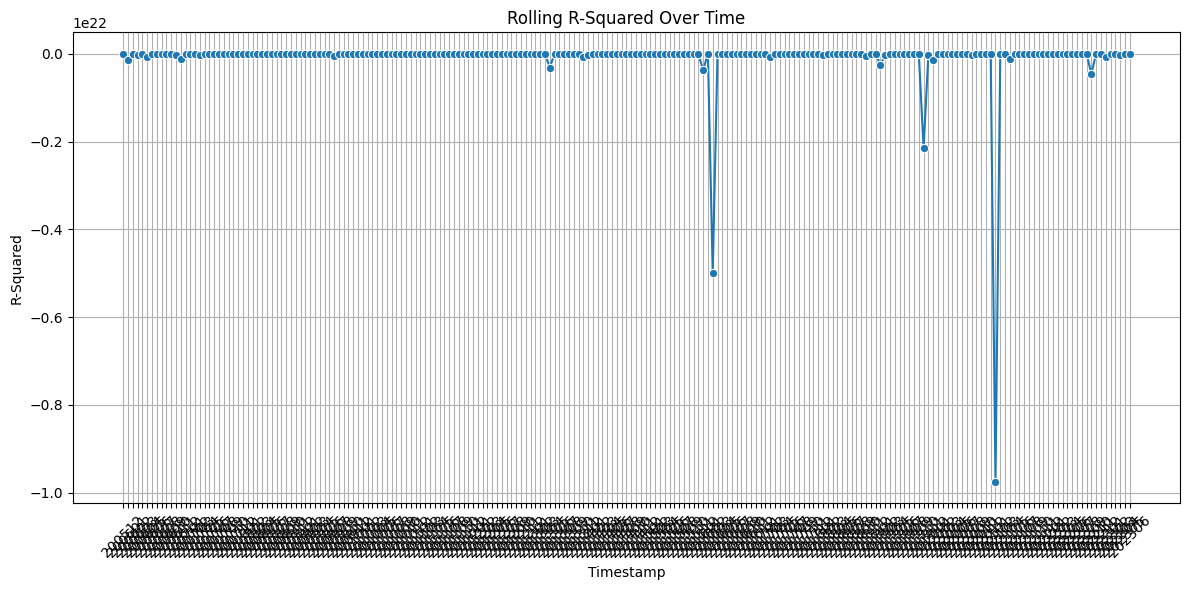

In [1]:
# Mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved R-squared diagnostics CSV file
r_squared_file = "/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_RSquared.csv"
r_squared_df = pd.read_csv(r_squared_file)

# Ensure the Timestamp column is treated as a string (or datetime) for better x-axis labels
r_squared_df["Timestamp"] = r_squared_df["Timestamp"].astype(str)

# Plot the R-squared values over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=r_squared_df, x="Timestamp", y="R-Squared", marker="o")
plt.title("Rolling R-Squared Over Time")
plt.xlabel("Timestamp")
plt.ylabel("R-Squared")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                            OLS Regression Results                            
Dep. Variable:         Return_Next 3M   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     20.78
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           7.60e-64
Time:                        00:56:40   Log-Likelihood:                -18307.
No. Observations:               14104   AIC:                         3.665e+04
Df Residuals:                   14086   BIC:                         3.679e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025 

  0%|          | 0/100 [00:00<?, ?it/s]

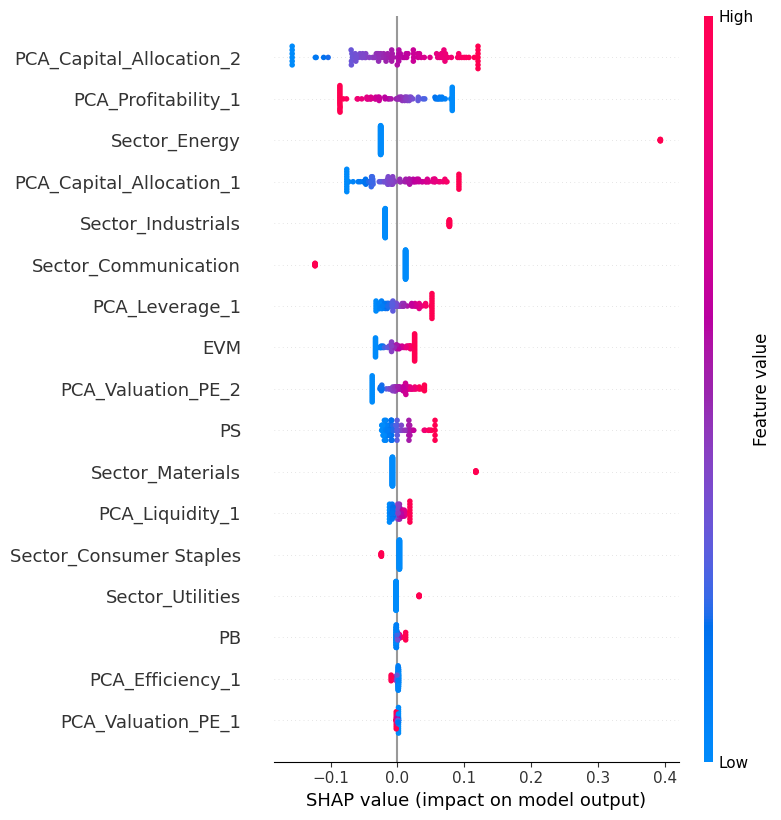

Intercept 0.3563632369283299
Prediction_local [-0.14226065]
Right: -0.08271998089618063


AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [5]:
# Install required packages (uncomment if needed)
!pip install shap lime pdpbox eli5

# Mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# ---------------------------
# Data Loading & Model Fitting
# ---------------------------
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 44.xlsx"
df = pd.read_excel(file_path)

# Drop rows with missing target and ensure Timestamp is integer
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

# Define target and features (adjust as needed)
y_var = "Return_Next 3M"
x_vars = df.columns[3:]  # e.g., excluding PERMNO and Timestamp
rolling_window = 36

# Select training window: last 36 timestamps prior to 202312
available_timestamps = sorted(df["Timestamp"].unique())
train_candidates = [t for t in available_timestamps if t < 202312]
if len(train_candidates) < rolling_window:
    raise ValueError("Not enough training data available prior to 202312.")
train_window = train_candidates[-rolling_window:]
train_data = df[df["Timestamp"].isin(train_window)]

# Prepare design matrix with constant
X_train = sm.add_constant(train_data[x_vars], has_constant="add")
y_train = train_data[y_var]

# Fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train).fit()
print(ols_model.summary())

# Define a prediction function for explainers (expects raw features without constant)
def predict_function(X):
    X_df = pd.DataFrame(X, columns=x_vars)
    X_df = sm.add_constant(X_df, has_constant="add")
    return ols_model.predict(X_df).values

# ---------------------------
# SHAP Analysis
# ---------------------------
import shap
# Use a subset of training data (dropping the constant) as background for the KernelExplainer
X_sample = X_train.iloc[:100].drop("const", axis=1)
explainer_shap = shap.KernelExplainer(predict_function, X_sample.values)
shap_values = explainer_shap.shap_values(X_sample.values, nsamples=100)
shap.summary_plot(shap_values, X_sample, feature_names=list(x_vars))

# ---------------------------
# LIME Analysis
# ---------------------------
from lime.lime_tabular import LimeTabularExplainer
# Prepare data for LIME (drop constant)
X_train_np = X_train.drop("const", axis=1).values
lime_explainer = LimeTabularExplainer(
    X_train_np,
    feature_names=list(x_vars),
    verbose=True,
    mode='regression'
)
# Explain one instance (e.g., the first row)
instance = X_train_np[0]
lime_exp = lime_explainer.explain_instance(instance, predict_function, num_features=10)
lime_exp.show_in_notebook(show_table=True)

# ---------------------------
# Partial Dependence Plot (PDP)
# ---------------------------
# If you encounter an error with pdp_isolate, check for file conflicts or try restarting your runtime.
from pdpbox import pdp, info_plots
feature_to_plot = x_vars[0]
# Generate the PDP isolate object; adjust num_grid_points if needed
pdp_go = pdp.pdp_isolate(
    model=ols_model,
    dataset=train_data[x_vars],
    model_features=list(x_vars),
    feature=feature_to_plot,
    num_grid_points=10
)
fig, axes = pdp.pdp_plot(pdp_go, feature_to_plot, plot_lines=True, frac_to_plot=1)
plt.show()

# ---------------------------
# Breakdown Plot using eli5 (with a scikit-learn estimator)
# ---------------------------
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.linear_model import LinearRegression

# Fit a LinearRegression model (using features without constant)
lr = LinearRegression()
X_train_noconst = train_data[x_vars]
lr.fit(X_train_noconst, y_train)

# Choose an instance for explanation (e.g., the first instance)
instance2 = X_train_noconst.iloc[0]
explanation = eli5.explain_prediction(lr, instance2, feature_names=list(x_vars))
# Display the breakdown plot in the notebook
eli5.show_prediction(lr, instance2, feature_names=list(x_vars))


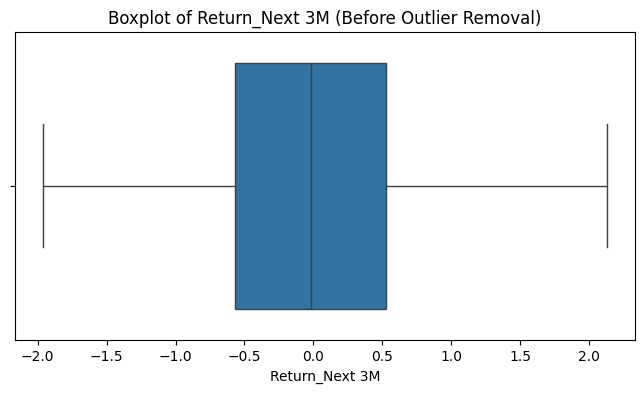

Removed 0 out of 108429 rows as extreme values.


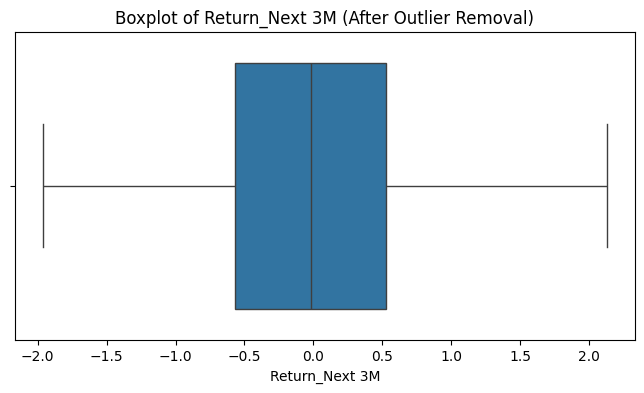

🟢 Processed Timestamp 200512 | R-Squared: 0.6592
🟢 Processed Timestamp 200601 | R-Squared: 0.6613
🟢 Processed Timestamp 200602 | R-Squared: 0.6619
🟢 Processed Timestamp 200603 | R-Squared: 0.6626
🟢 Processed Timestamp 200604 | R-Squared: 0.6651
🟢 Processed Timestamp 200605 | R-Squared: 0.6664
🟢 Processed Timestamp 200606 | R-Squared: 0.6702
🟢 Processed Timestamp 200607 | R-Squared: 0.6726
🟢 Processed Timestamp 200608 | R-Squared: 0.6744
🟢 Processed Timestamp 200609 | R-Squared: 0.6699
🟢 Processed Timestamp 200610 | R-Squared: 0.6763
🟢 Processed Timestamp 200611 | R-Squared: 0.6740
🟢 Processed Timestamp 200612 | R-Squared: 0.6748
🟢 Processed Timestamp 200701 | R-Squared: 0.6749
🟢 Processed Timestamp 200702 | R-Squared: 0.6739
🟢 Processed Timestamp 200703 | R-Squared: 0.6733
🟢 Processed Timestamp 200704 | R-Squared: 0.6757
🟢 Processed Timestamp 200705 | R-Squared: 0.6724
🟢 Processed Timestamp 200706 | R-Squared: 0.6721
🟢 Processed Timestamp 200707 | R-Squared: 0.6763
🟢 Processed Timestam

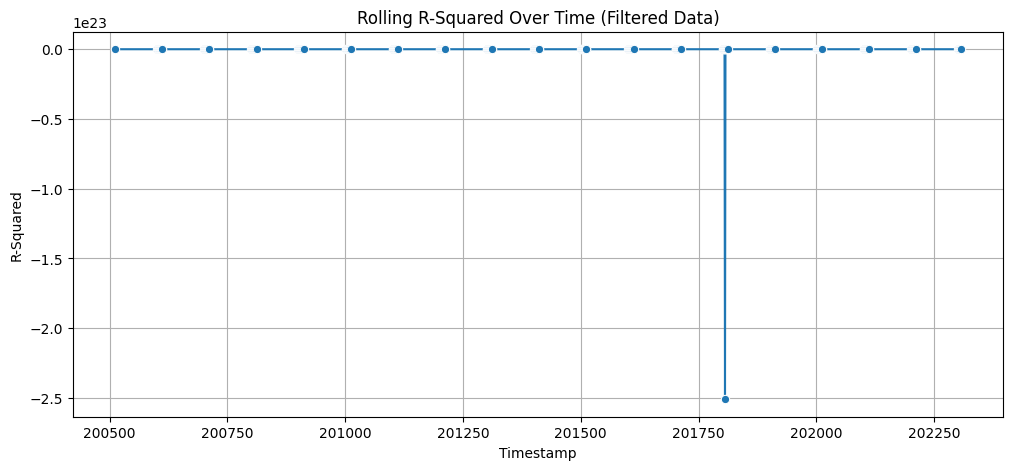

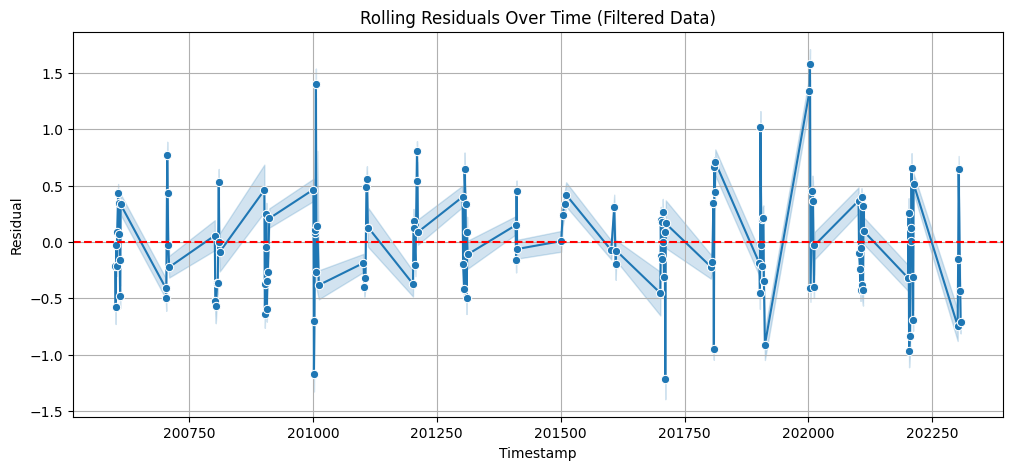

✅ RollingOLS Diagnostics (Filtered) Saved Successfully!


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# ---------------------------
# 1. Load Data & Remove Extreme Values
# ---------------------------
# Load the file (adjust file_path if needed)
file_path = "/content/drive/My Drive/Colab Notebooks/823 Project/Final 44.xlsx"
df = pd.read_excel(file_path)

# Drop rows with missing target and ensure Timestamp is integer
df = df.dropna(subset=["Return_Next 3M"]).reset_index(drop=True)
df["Timestamp"] = df["Timestamp"].astype(int)

# Plot a boxplot of the target to inspect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Return_Next 3M"])
plt.title("Boxplot of Return_Next 3M (Before Outlier Removal)")
plt.show()

# Remove extreme values from the target using the IQR method
y_var = "Return_Next 3M"
Q1 = df[y_var].quantile(0.25)
Q3 = df[y_var].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df[y_var] >= lower_bound) & (df[y_var] <= upper_bound)]
print(f"Removed {len(df) - len(df_filtered)} out of {len(df)} rows as extreme values.")

# Plot a boxplot after removal
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_filtered[y_var])
plt.title("Boxplot of Return_Next 3M (After Outlier Removal)")
plt.show()

# ---------------------------
# 2. RollingOLS Diagnostics on Filtered Data
# ---------------------------
# Define your features; adjust if needed (assuming columns from the 4th onward are features)
x_vars = df_filtered.columns[3:]  # Excluding PERMNO and Timestamp if they are in first columns
rolling_window = 36

# Get sorted unique timestamps from the filtered data
timestamps = sorted(df_filtered["Timestamp"].unique())

# Initialize storage lists for diagnostics
rolling_coefficients = []
r_squared_values = []
timestamps_recorded = []
residuals_values = []     # To store each residual value
residuals_timestamps = [] # To store corresponding timestamp for each residual

# Run RollingOLS over a moving window
for i in range(len(timestamps) - rolling_window - 5):
    train_start = timestamps[i]
    train_end = timestamps[i + rolling_window - 1]

    # Ensure there is room for validation (next timestamp)
    if (i + rolling_window + 5) >= len(timestamps):
        break

    # Select training data (within the current window) and validation data (next timestamp)
    train_data = df_filtered[(df_filtered["Timestamp"] >= train_start) & (df_filtered["Timestamp"] <= train_end)]
    validation_data = df_filtered[df_filtered["Timestamp"] == timestamps[i + rolling_window]]

    # Ensure data availability
    if len(train_data) < rolling_window or validation_data.empty:
        continue

    # Prepare design matrices (add constant)
    X_train = sm.add_constant(train_data[x_vars], has_constant="add")
    y_train = train_data[y_var]
    X_validation = sm.add_constant(validation_data[x_vars], has_constant="add")

    # Fit the RollingOLS model on the training window
    rolling_model = RollingOLS(y_train, X_train, window=rolling_window).fit()

    # Save the last available coefficients
    latest_coefficients = rolling_model.params.iloc[-1].values
    rolling_coefficients.append(latest_coefficients)

    # Save the average R-squared from the rolling model
    avg_r_squared = rolling_model.rsquared.mean()
    r_squared_values.append(avg_r_squared)
    timestamps_recorded.append(train_end)

    # Compute fitted values and residuals on the validation data
    fitted_values = np.dot(X_validation, latest_coefficients)
    actual_values = validation_data[y_var].values

    # Store each residual along with its timestamp
    if len(actual_values) == len(fitted_values):
        residuals = actual_values - fitted_values
        for r in residuals:
            residuals_values.append(r)
            residuals_timestamps.append(timestamps[i + rolling_window])
    else:
        for _ in range(len(actual_values)):
            residuals_values.append(np.nan)
            residuals_timestamps.append(timestamps[i + rolling_window])

    print(f"🟢 Processed Timestamp {train_end} | R-Squared: {avg_r_squared:.4f}")

# Convert diagnostics to DataFrames
coefficients_df = pd.DataFrame(rolling_coefficients, columns=["Intercept"] + list(x_vars), index=timestamps_recorded)
r_squared_df = pd.DataFrame({"Timestamp": timestamps_recorded, "R-Squared": r_squared_values})
residuals_df = pd.DataFrame({"Timestamp": residuals_timestamps, "Residual": residuals_values})

# ---------------------------
# 3. Plot the Diagnostics
# ---------------------------
# Plot R-Squared Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="R-Squared", data=r_squared_df, marker="o")
plt.title("Rolling R-Squared Over Time (Filtered Data)")
plt.xlabel("Timestamp")
plt.ylabel("R-Squared")
plt.grid(True)
plt.show()

# Plot Residuals Over Time
plt.figure(figsize=(12, 5))
sns.lineplot(x="Timestamp", y="Residual", data=residuals_df, marker="o")
plt.title("Rolling Residuals Over Time (Filtered Data)")
plt.xlabel("Timestamp")
plt.ylabel("Residual")
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

# ---------------------------
# 4. Save the New Diagnostics to Files
# ---------------------------
coefficients_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Coefficients_Filtered.csv")
r_squared_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_RSquared_Filtered.csv")
residuals_df.to_csv("/content/drive/My Drive/Colab Notebooks/823 Project/RollingOLS_Residuals_Filtered.csv")

print("✅ RollingOLS Diagnostics (Filtered) Saved Successfully!")


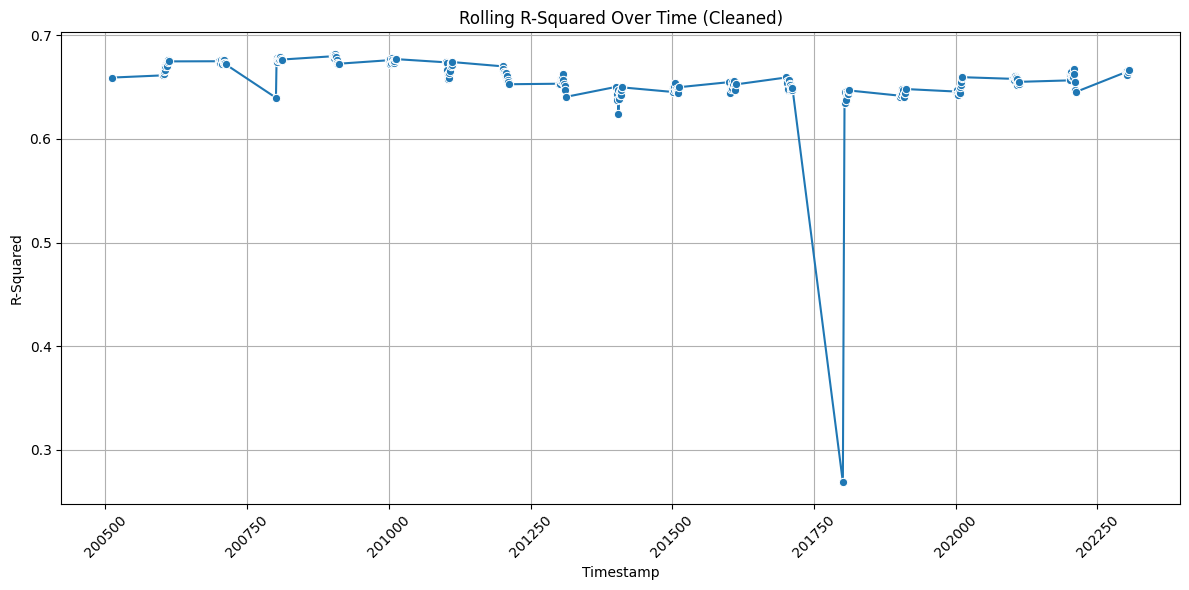

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume r_squared_df is the DataFrame with columns "Timestamp" and "R-Squared"
# For example, from your earlier code:
# r_squared_df = pd.DataFrame({"Timestamp": timestamps_recorded, "R-Squared": r_squared_values})

# Create a cleaned R-squared column: set any value outside [-1, 1] to NaN
r_squared_df["R_squared_clean"] = r_squared_df["R-Squared"].apply(lambda x: x if -1 <= x <= 1 else np.nan)

# Alternatively, to fill extreme values with zero, you could use:
# r_squared_df["R_squared_clean"] = r_squared_df["R-Squared"].apply(lambda x: x if -1 <= x <= 1 else 0)

# Plot the cleaned R-squared values over time
plt.figure(figsize=(12, 6))
sns.lineplot(x="Timestamp", y="R_squared_clean", data=r_squared_df, marker="o")
plt.title("Rolling R-Squared Over Time (Cleaned)")
plt.xlabel("Timestamp")
plt.ylabel("R-Squared")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


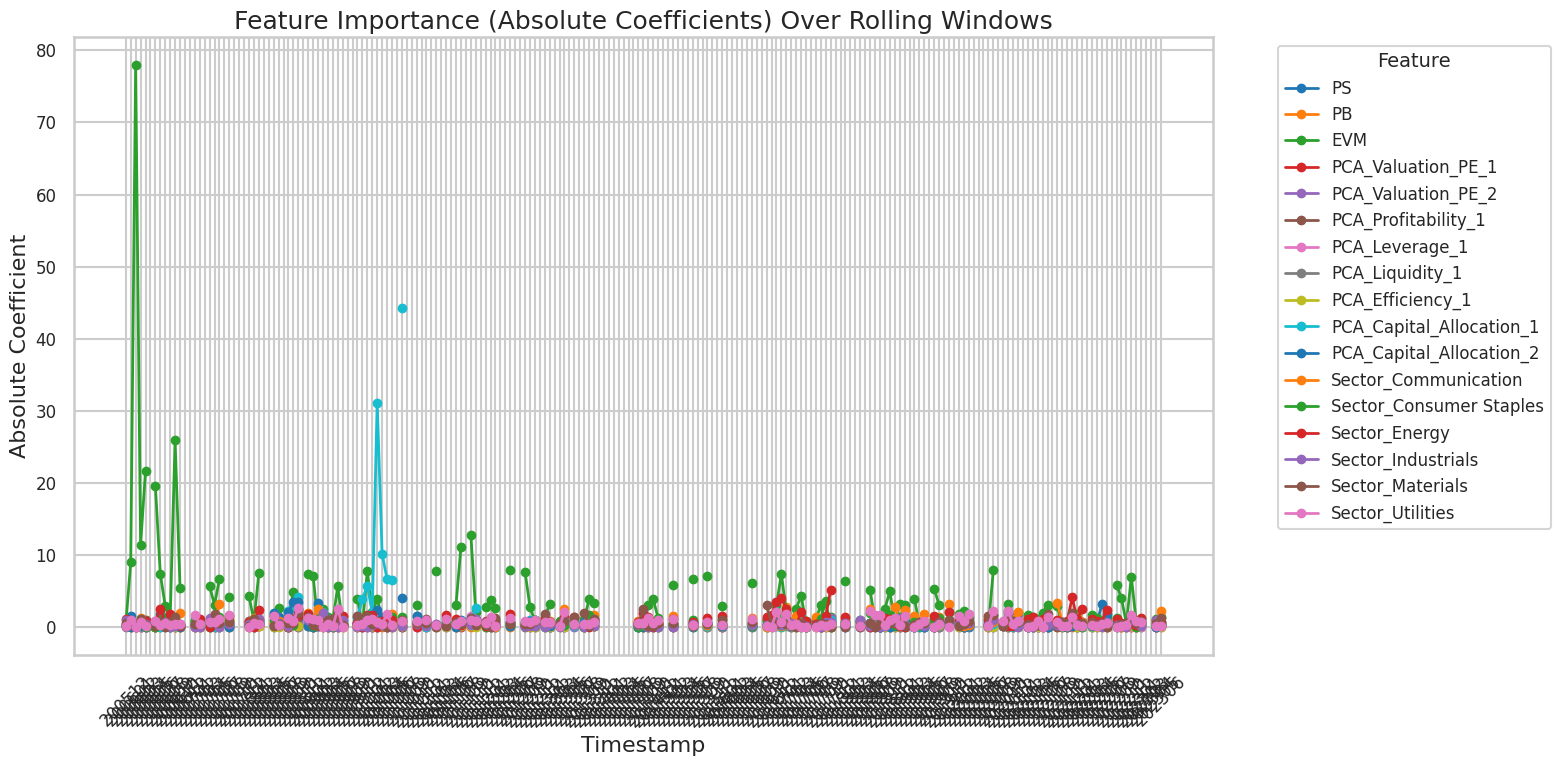

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume coefficients_df is already available with index=Timestamp and columns=["Intercept", feature1, feature2, ...]

# Drop the intercept and compute absolute coefficients as a measure of importance.
feature_coefs = coefficients_df.drop(columns=["Intercept"])
abs_feature_coefs = feature_coefs.abs()

# Reset the index so that Timestamp is a column.
abs_feature_coefs = abs_feature_coefs.reset_index().rename(columns={"index": "Timestamp"})

# Melt the DataFrame to long format for plotting
abs_feature_coefs_melt = abs_feature_coefs.melt(id_vars=["Timestamp"],
                                                var_name="Feature",
                                                value_name="AbsoluteCoefficient")

# Convert Timestamp to string for clearer x-axis if needed.
abs_feature_coefs_melt["Timestamp"] = abs_feature_coefs_melt["Timestamp"].astype(str)

# Set a color palette and style
sns.set(style="whitegrid", context="talk")
palette = sns.color_palette("tab10", n_colors=abs_feature_coefs_melt["Feature"].nunique())

plt.figure(figsize=(16, 8))
# Use markers every few points by plotting each feature separately
features = abs_feature_coefs_melt["Feature"].unique()
for i, feature in enumerate(features):
    subset = abs_feature_coefs_melt[abs_feature_coefs_melt["Feature"] == feature]
    plt.plot(subset["Timestamp"], subset["AbsoluteCoefficient"],
             marker='o', markersize=6, label=feature, color=palette[i], linewidth=2)

plt.title("Feature Importance (Absolute Coefficients) Over Rolling Windows", fontsize=18)
plt.xlabel("Timestamp", fontsize=16)
plt.ylabel("Absolute Coefficient", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Feature", fontsize=12, title_fontsize=14, loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [15]:
# Compute summary statistics for each feature's absolute coefficient
diagnostics_summary = abs_feature_coefs.drop(columns=["Timestamp"]).describe().T
diagnostics_summary = diagnostics_summary[['mean', 'std', 'min', 'max']]
diagnostics_summary = diagnostics_summary.rename(columns={
    "mean": "Mean",
    "std": "Std Dev",
    "min": "Min",
    "max": "Max"
})
print("Feature Importance Diagnostics Summary (Absolute Coefficients):")
print(diagnostics_summary)


Feature Importance Diagnostics Summary (Absolute Coefficients):
                              Mean   Std Dev       Min        Max
PS                        0.352871  0.331390  0.001124   1.856417
PB                        0.312677  0.378189  0.002482   2.808005
EVM                       3.929201  7.493367  0.027163  77.907133
PCA_Valuation_PE_1        0.303500  0.277100  0.003836   1.847584
PCA_Valuation_PE_2        0.214345  0.216394  0.000454   1.302897
PCA_Profitability_1       0.392155  0.316405  0.003493   1.921545
PCA_Leverage_1            0.358261  0.310947  0.004151   1.518535
PCA_Liquidity_1           0.276475  0.224273  0.001770   0.956123
PCA_Efficiency_1          0.143569  0.120646  0.002525   0.729683
PCA_Capital_Allocation_1  1.359732  4.738973  0.009368  44.304450
PCA_Capital_Allocation_2  0.679636  0.757450  0.008936   4.043232
Sector_Communication      0.879341  0.738353  0.001709   3.395184
Sector_Consumer Staples   0.738901  0.570360  0.007273   3.578340
Sector_Energ

  0%|          | 0/200 [00:00<?, ?it/s]

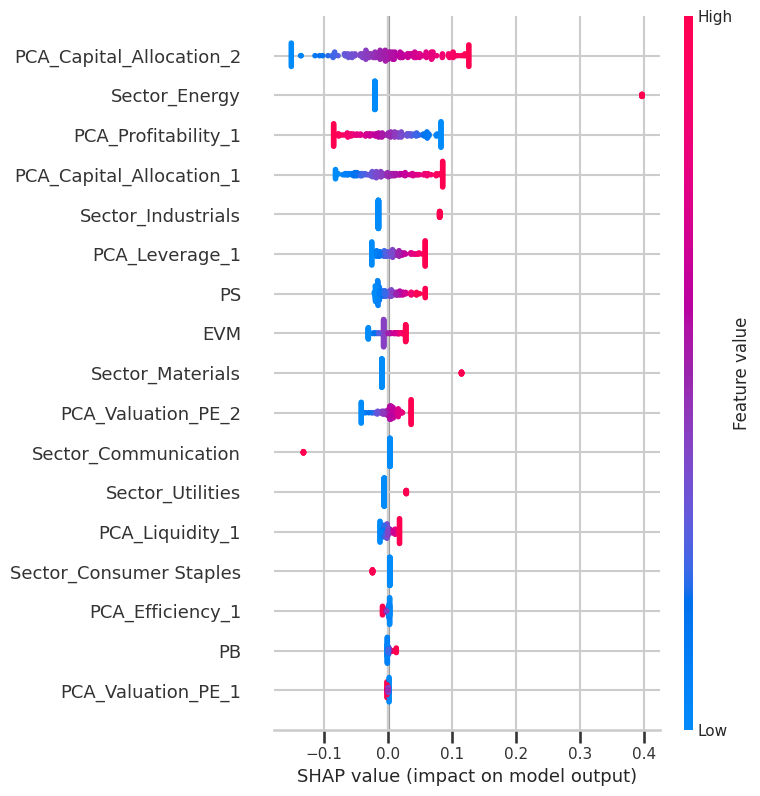

In [16]:
import shap
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Prepare the training data for SHAP analysis ---
# Assume X_train is your design matrix that already includes the constant column,
# and x_vars is the list of feature names (excluding the constant)
# For SHAP, we remove the constant so that our data only contains the raw features.
X_train_no_const = X_train.drop("const", axis=1)

# Use a subset of the training data as background for the KernelExplainer
background = X_train_no_const.iloc[:100].values

# --- Define a prediction function for SHAP ---
def predict_fn(X):
    """
    Given a numpy array X of shape (n_samples, n_features) without the constant,
    convert it to a DataFrame, add the constant column, and return model predictions.
    """
    X_df = pd.DataFrame(X, columns=x_vars)
    # Add the constant column exactly as in your training data.
    X_df = sm.add_constant(X_df, has_constant="add")
    return ols_model.predict(X_df).values

# --- Create a SHAP KernelExplainer ---
explainer = shap.KernelExplainer(predict_fn, background)

# --- Compute SHAP values for a sample of the training data ---
# For speed, we'll explain only the first 200 rows of your training data (without constant).
X_sample = X_train_no_const.iloc[:200].values
shap_values = explainer.shap_values(X_sample, nsamples=100)

# --- Produce the SHAP Summary Plot ---
# Convert the sample back to a DataFrame for clear labeling.
X_sample_df = X_train_no_const.iloc[:200].copy()
shap.summary_plot(shap_values, X_sample_df, feature_names=x_vars)


In [17]:
import shap
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Prepare data for SHAP analysis ---
# Assume:
# - X_train is your design matrix (with a constant column)
# - x_vars is the list of feature names (excluding the constant)
# - ols_model is your previously fitted OLS model
# First, drop the constant for SHAP (we'll re-add it in the prediction function)
X_train_no_const = X_train.drop("const", axis=1)

# Choose a background sample (first 100 rows) for the KernelExplainer
background = X_train_no_const.iloc[:100].values

# --- Define the prediction function for SHAP ---
def predict_fn(X):
    """
    Given a numpy array X (without constant), convert to DataFrame,
    add constant, and return model predictions.
    """
    X_df = pd.DataFrame(X, columns=x_vars)
    X_df = sm.add_constant(X_df, has_constant="add")
    return ols_model.predict(X_df).values

# --- Create SHAP KernelExplainer and compute SHAP values ---
explainer = shap.KernelExplainer(predict_fn, background)
# Use a sample of 200 rows from the training data (without constant) for explanation
X_sample = X_train_no_const.iloc[:200].values
# Compute SHAP values (nsamples can be adjusted for speed/accuracy)
shap_values = explainer.shap_values(X_sample, nsamples=100)

# --- Convert SHAP values to DataFrame for analysis ---
shap_df = pd.DataFrame(shap_values, columns=x_vars)

# --- Compute summary statistics: mean absolute SHAP value per feature ---
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

print("Mean Absolute SHAP Values per Feature:")
print(mean_abs_shap)

# Optionally, also compute the standard deviation of the absolute SHAP values:
std_abs_shap = shap_df.abs().std().sort_values(ascending=False)
print("\nStandard Deviation of Absolute SHAP Values per Feature:")
print(std_abs_shap)


  0%|          | 0/200 [00:00<?, ?it/s]

Mean Absolute SHAP Values per Feature:
PCA_Capital_Allocation_2    0.057194
Sector_Energy               0.049103
PCA_Profitability_1         0.045375
PCA_Capital_Allocation_1    0.040546
Sector_Industrials          0.026747
PCA_Leverage_1              0.020837
PS                          0.017106
EVM                         0.017083
Sector_Materials            0.016779
PCA_Valuation_PE_2          0.014480
Sector_Communication        0.009197
Sector_Utilities            0.008524
PCA_Liquidity_1             0.008339
Sector_Consumer Staples     0.004647
PCA_Efficiency_1            0.002162
PB                          0.001743
PCA_Valuation_PE_1          0.000745
dtype: float64

Standard Deviation of Absolute SHAP Values per Feature:
Sector_Energy               0.099311
PCA_Capital_Allocation_2    0.045485
PCA_Profitability_1         0.029366
PCA_Capital_Allocation_1    0.028723
Sector_Communication        0.028370
Sector_Materials            0.025879
Sector_Industrials          0.024832
P

Intercept 0.24122200155508314
Prediction_local [-0.01708358]
Right: -0.06617235098702154
LIME Explanation (Feature Contributions):
Sector_Energy <= 0.00: -0.4250170814722072
Sector_Communication <= 0.00: 0.13648911245270634
Sector_Materials <= 0.00: -0.12297453050820867
Sector_Industrials > 0.00: 0.09668669447244528
PCA_Capital_Allocation_1 > 0.48: 0.08193679491797722
PCA_Leverage_1 > 0.86: 0.046440744187152036
Sector_Utilities <= 0.00: -0.03129841175822124
-0.40 < PCA_Capital_Allocation_2 <= -0.10: -0.030317582868171128
0.13 < PCA_Profitability_1 <= 0.81: -0.030275828884235117
Sector_Consumer Staples <= 0.00: 0.028893592590274908
PCA_Liquidity_1 <= -0.48: -0.01338081195156858
PCA_Efficiency_1 > 0.71: -0.011925770606075388
0.33 < PCA_Valuation_PE_2 <= 1.30: 0.00990858287576379
0.30 < EVM <= 0.40: 0.008261071565389114
-0.04 < PB <= 0.52: -0.0017290963227302313
-0.24 < PS <= 0.75: -0.0008847668517821856
-0.07 < PCA_Valuation_PE_1 <= 0.92: 0.0008817078662153743


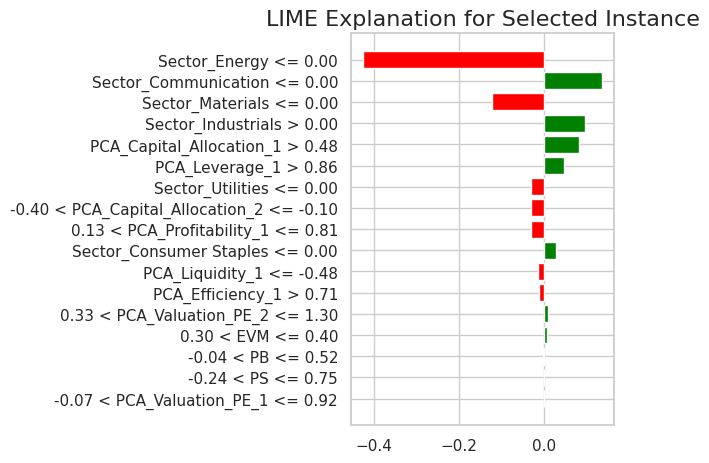

In [20]:
import lime
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Prepare the Data for LIME
# ---------------------------
# Assume X_train is your design matrix (with a constant column) used for OLS,
# and x_vars is the list of feature names (excluding the constant).
# Remove the constant column for LIME processing:
X_train_no_const = X_train.drop("const", axis=1)

# ---------------------------
# Define the LIME Explainer
# ---------------------------
lime_explainer = LimeTabularExplainer(
    X_train_no_const.values,
    feature_names=x_vars,
    mode='regression',
    verbose=True,
    random_state=42
)

# ---------------------------
# Define the Prediction Function for LIME
# ---------------------------
def predict_fn(X):
    """
    Given a numpy array X (of raw features, without constant),
    convert to DataFrame, add the constant, and return predictions.
    """
    X_df = pd.DataFrame(X, columns=x_vars)
    X_df = sm.add_constant(X_df, has_constant="add")
    return ols_model.predict(X_df).values

# ---------------------------
# Generate LIME Explanation for a Single Instance
# ---------------------------
# Select the first instance from the training data for explanation
instance = X_train_no_const.iloc[0].values

lime_exp = lime_explainer.explain_instance(instance, predict_fn, num_features=len(x_vars))

# ---------------------------
# Print LIME Explanation Values
# ---------------------------
lime_values = lime_exp.as_list()
print("LIME Explanation (Feature Contributions):")
for feature, weight in lime_values:
    print(f"{feature}: {weight}")

# ---------------------------
# Plot the LIME Explanation
# ---------------------------
# Set the theme with a white grid background
sns.set_theme(style="whitegrid")
fig = lime_exp.as_pyplot_figure()
plt.title("LIME Explanation for Selected Instance", fontsize=16)
plt.tight_layout()
plt.show()
